In [6]:
import os
import pandas as pd
from pandas import DataFrame
from keras.models import Sequential, Model, Sequential, load_model
from keras.layers import Dense, Input, Activation, Conv2D, MaxPool2D, Flatten, UpSampling2D, Conv2DTranspose, Reshape, LeakyReLU, Concatenate
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.utils import np_utils, plot_model
import matplotlib.pyplot as plt
# matplotlib.use("TkAgg")
%matplotlib inline
import numpy as np
np.random.seed(1)
from sklearn.metrics import confusion_matrix
from PIL import Image
import random
import math

In [ ]:
if not os.path.exists('model/'):
    os.makedirs('model/')

In [7]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('x_train\n', x_train.shape)
print('y_train\n', y_train.shape, y_train[0])
print('x_test\n', x_test.shape)
print('y_test\n', y_test.shape)

x_train
 (60000, 28, 28)
y_train
 (60000,) 5
x_test
 (10000, 28, 28)
y_test
 (10000,)


In [8]:
# data pre-processing
x_train = x_train.astype('float32') / 127.5 - 1       # minmax_normalized
x_test = x_test.astype('float32') / 127.5 - 1         # minmax_normalized
# x_train = x_train.astype('float32') / 255.       # minmax_normalized
# x_test = x_test.astype('float32') / 255.         # minmax_normalized
x_train = x_train.reshape((-1, 28*28))
x_test = x_test.reshape((-1, 28*28))
print(x_train.shape)
print(x_test.shape)
# y_train = np_utils.to_categorical(y_train, num_classes=10)
# y_test = np_utils.to_categorical(y_test, num_classes=10)

(60000, 784)
(10000, 784)


In [9]:
# in order to plot in a 2D figure
encoding_dim = 2

x_input = Input(shape=(784,))
encoded = Dense(512, activation='tanh')(x_input)
encoded = Dense(256, activation='tanh')(encoded)
encoded = Dense(128, activation='tanh')(encoded)
encoded = Dense(64, activation='tanh')(encoded)
encoder_output = Dense(encoding_dim, name='encoder_output')(encoded)

decoded_input = Input(shape=(encoding_dim,))
decoded = Dense(64, activation='tanh')(decoded_input)
decoded = Dense(128, activation='tanh')(decoded)
decoded = Dense(256, activation='tanh')(decoded)
decoded = Dense(512, activation='tanh')(decoded)
decoded_output = Dense(784, activation='tanh', name='decoder_output')(decoded)

encoder = Model(inputs=x_input, outputs=encoder_output)

decoder = Model(decoded_input, decoded_output)

del encoder
encoder = load_model('model/encoder.h5')
del decoder
decoder = load_model('model/decoder.h5')

ec_out = encoder(x_input)
dc_out = decoder(ec_out)
autoencoder = Model(x_input, dc_out)

autoencoder.compile(loss='mse', optimizer=Adam())

encoder.summary()
decoder.summary()
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
encoder_output (Dense)       (None, 2)                 130       
Total params: 574,530
Trainable params: 574,530
Non-trainable params: 0
_________________________________________________________________
____

/Users/ianfan/anaconda3/envs/spinningup/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [11]:
# training
autoencoder.fit(x_train, x_train, epochs=3, batch_size=256, shuffle=True)

encoder.save('model/encoder.h5')
decoder.save('model/decoder.h5')

Epoch 1/3
60000/60000 [==============================] - 4s 62us/step - loss: 0.1420
Epoch 2/3
60000/60000 [==============================] - 3s 56us/step - loss: 0.1412
Epoch 3/3
60000/60000 [==============================] - 3s 56us/step - loss: 0.1410


(10, 784)


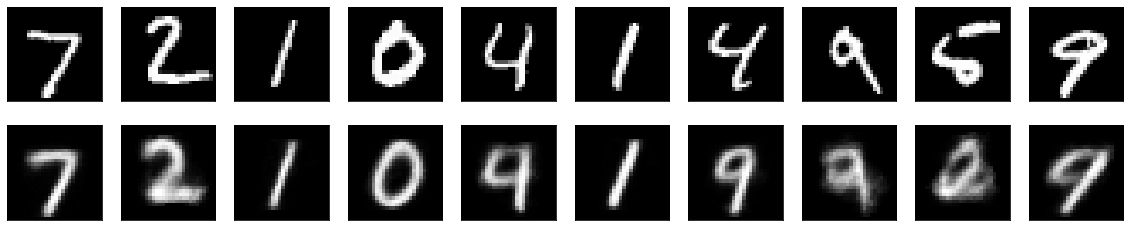

In [10]:
n = 10
decoded_imgs = autoencoder.predict(x_test[:n])
print(decoded_imgs.shape)
  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

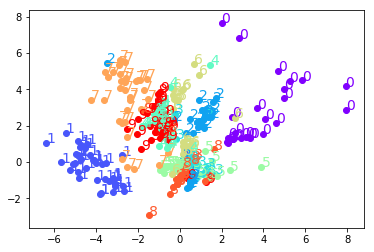

In [29]:
from matplotlib import cm

view_data = x_test[:300]
encoded_data = encoder.predict(view_data)
X, Y = encoded_data[:, 0], encoded_data[:, 1]

for x, y, s in zip(X, Y, y_test):
    c = cm.rainbow(int(255*s/9)); 
    plt.scatter(x, y, c=[c])
    plt.text(x, y, s, fontdict={'size': 14, 'color':c})

plt.show()

(225, 784)


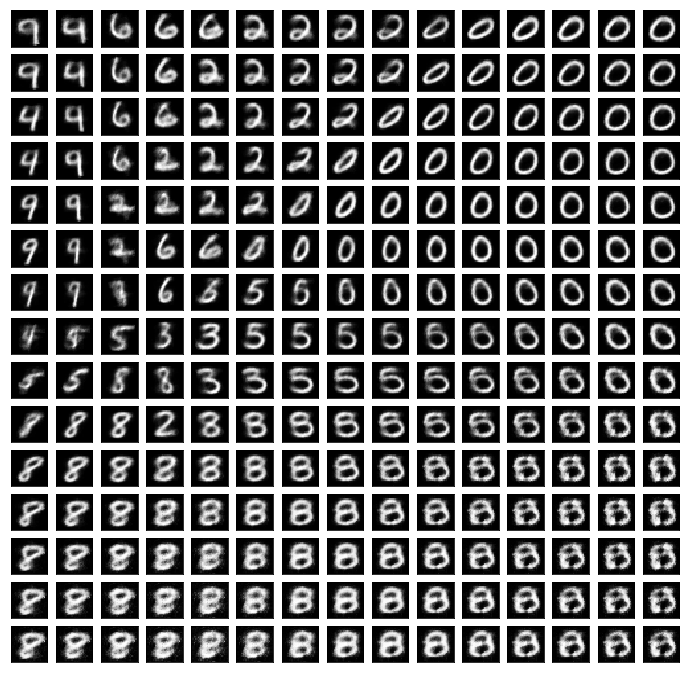

In [15]:
length = 15
x_lins = np.linspace(-1, 5, length, dtype=np.float32)
y_lins = np.linspace(-4, 4, length, dtype=np.float32)
data_draw = np.vstack([np.hstack((x_lins[:,np.newaxis], np.ones([length, 1])*y_lins[length-1-i])) for i in range(length)])
draw_ = decoder.predict(data_draw)
print(draw_.shape)
num = length*length
row = int(math.ceil(num/length))
fig, axes = plt.subplots(row, length, figsize=(length*(12/length), row*(12/length)))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.reshape(draw_[i],[28,28]), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

(256, 256)


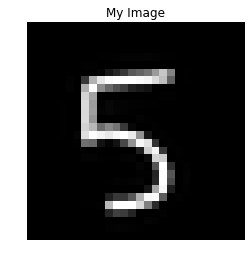

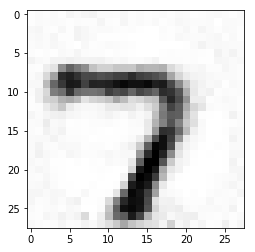

In [9]:
from PIL import Image
im = Image.open("./my_image1.png")
print(np.array(im).shape)

im = im.resize((28, 28), Image.ANTIALIAS) #resize the image
im = np.array(im) #convert to an array
im2 = im/np.max(im).astype(float) #normalise input

plt.imshow(im2, cmap='gray')
plt.title('My Image')
plt.axis('off')
plt.show()

test_image = np.reshape(im2, [1,784]) # reshape it to our input placeholder shape

d_ = autoencoder.predict(test_image)

plt.imshow(np.reshape(d_, (28, 28)), cmap='gray')

In [10]:
from sklearn import cluster, metrics

features = encoder.predict(x_train)
print(features[0])

kmeans = cluster.KMeans(n_clusters=10)
kmeans_fit = kmeans.fit(features)
kmeans_label = kmeans_fit.labels_

silhouette_avg = metrics.silhouette_score(x_train, kmeans_label)
print("績效\n",silhouette_avg) # 這個數值愈接近 1 表示績效愈好，反之愈接近 -1 表示績效愈差。

[0.4440046  0.48778576]
績效
 0.0044158148


[2 3 4 9 0 8 1 2 1 0 2 5 5 2 1 6 8 5 2 0 4 3 0 9 2 5 0 2 5 0]
[0 1 2 3 4 5 6 7 8 9]


(array([12017.,  3862., 10959.,  3249.,  3429., 13795.,  2626.,  1890.,
         5870.,  2303.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

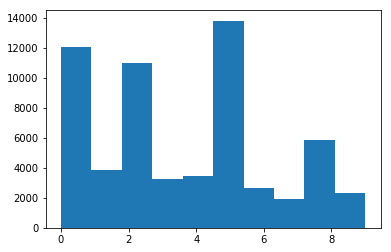

In [11]:
print(kmeans_label[:30])
print(np.unique(kmeans_label))
plt.hist(kmeans_label)

[[   2   50  384   93 4827  104  235 1352  194 4776]
 [   0 3827    7    0    0    0    1   20    5    2]
 [ 831  122  564 2483  323 1630 3744  515  368  379]
 [3111    0   65   10    1   12   19    0   21   10]
 [  84    0   24    9  533   23  555 1682    4  515]
 [  25  467  601 3446   65 3631  100  107 5180  173]
 [   0    2    7    3    2    0    0 2549    5   58]
 [1811    0   32    0    4    2   29    3    3    6]
 [  59   18 4262   84   83   19 1232   23   63   27]
 [   0 2256   12    3    4    0    3   14    8    3]]


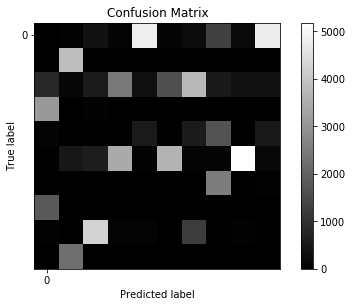

In [12]:
#Confusion Matrix
cm = metrics.confusion_matrix(kmeans_label, y_train)
print(cm)

#Plotting confusion Matrix
plt.imshow(cm, interpolation='nearest')
plt.colorbar()
number_of_class = 10
tick_marks = np.arange(len(np.unique(10)))
plt.xticks(tick_marks, range(number_of_class))
plt.yticks(tick_marks, range(number_of_class))
plt.tight_layout()
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()